# Mean Risk Optimisation
## Loading Packages

In [17]:
using PortfolioOptimiser, PrettyTables, TimeSeries, DataFrames, CSV, Clarabel

## Loading sample data

In [18]:
wdffmt = (v, i, j) -> begin
    if j == 1
        return v
    else
        return "$(round(v*100, digits=3))%"
    end
end

# Reading the data.
A = TimeArray(CSV.File("../test/assets/stock_prices.csv"); timestamp=:date)
# Computing returns.
Y = percentchange(A)
# Turning into a dataframe and rop missing values.
returns = dropmissing!(DataFrame(Y))

pretty_table(returns[1:5, :]; formatters = wdffmt)

┌────────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┐
│  timestamp │    GOOG │    AAPL │      FB │    BABA │    AMZN │      GE │     AMD │     WMT │     BAC │      GM │       T │     UAA │    SHLD │     XOM │     RRC │     BBY │      MA │     PFE │     JPM │    SBUX │
│       Date │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │
├────────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┤
│ 2014-09-22 │ -1.461% │  0.099% │ -1.425% │  -4.26% │ -2.058% │ -0.799% │ -1.312% │  -0.69% │  0.472% │ -1.473% │  0.085% │ -2.836% │ -1.01

## Minimal Working Example

In this example we use all the default values for the function arguments. Later tutorials will make use of the more advanced features.

In [19]:
# We instantiate the portfolio instance.
portfolio = Portfolio(;
    # Returns dataframe
    returns = returns,
    # Solvers is a Dictionary.
    solvers = Dict(
        # We will use the Clarabel.jl optimiser. In this case we use a dictionary
        # for the value, but we can also use named tuples, all we need are key-value
        # pairs.
        :Clarabel => Dict(
            # :solver key must contain the optimiser structure.
            :solver => Clarabel.Optimizer,
            # :params key is optional, but if it is present, it defines solver-specific
            # attributes/configurations. This often needs to be a dictionary as the 
            # solver attributes are usually strings.
            :params => Dict("verbose" => false, "max_step_fraction" => 0.75),
        ),
    ),
)

Portfolio{Vector{String}, Vector{Date}, Matrix{Float64}, Bool, Float64, Float64, Float64, Int64, Int64, Float64, Vector{String}, Vector{Date}, Matrix{Float64}, Matrix{Float64}, Union{Nothing, Real, AbstractVector{<:Real}}, Union{Nothing, Real, AbstractVector{<:Real}}, Float64, Float64, Int64, Float64, Union{Nothing, Real}, Union{Nothing, Real}, Union{Nothing, Integer}, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Int64, Float64, Vector{Float64}, Symbol, Float64, Vector{Float64}, Vector{Float64}, Vector{Float64}, Matrix{Float64}, Vector{Float64}, Union{Real, Vector{<:Real}}, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Union{Nothing, Real, AbstractVector{<:Real}}, Float64, Float64, Float64, Float64, Symbol, Vector{Float64}, Symbol, Bool, Matrix{Float64}, Matrix{Float64}, Matrix{Float64}, Symbol, SparseArrays.S

Note how many fields are in the portfolio structure. We will be using many more of these in the future. It basically keeps track of everything
Before we optimise we need to compute some statistics. 

In [20]:
asset_statistics!(portfolio)

We can then optimise our portfolio.

In [21]:
w = opt_port!(portfolio)
pretty_table(w; formatters=wdffmt)

┌─────────┬─────────┐
│ tickers │ weights │
│  String │ Float64 │
├─────────┼─────────┤
│    GOOG │    0.0% │
│    AAPL │    0.0% │
│      FB │    0.0% │
│    BABA │    0.0% │
│    AMZN │ 47.444% │
│      GE │    0.0% │
│     AMD │  5.589% │
│     WMT │    0.0% │
│     BAC │    0.0% │
│      GM │    0.0% │
│       T │    0.0% │
│     UAA │    0.0% │
│    SHLD │    0.0% │
│     XOM │    0.0% │
│     RRC │    0.0% │
│     BBY │ 13.876% │
│      MA │ 22.214% │
│     PFE │    0.0% │
│     JPM │ 10.876% │
│    SBUX │    0.0% │
└─────────┴─────────┘


We can plot the portfolio composition as a bar chart.

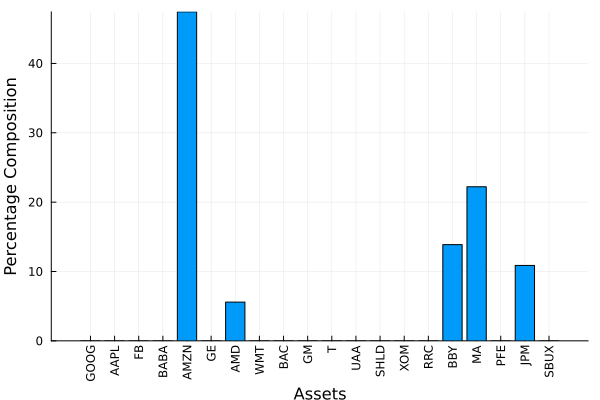

In [22]:
fig1 = plot_bar(portfolio)

We can also plot various expected ranges of returns of this portfolio.

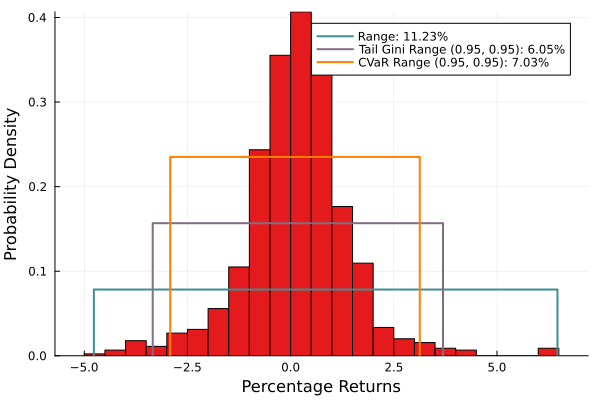

In [23]:
fig2 = plot_range(portfolio)

We can view downside risk measures as well.

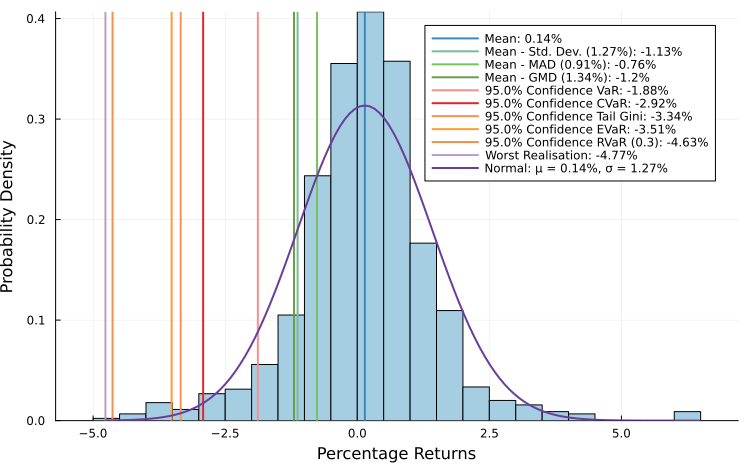

In [24]:
fig3 = plot_hist(portfolio)

And we can view cumulative uncompounded drawdowns too.

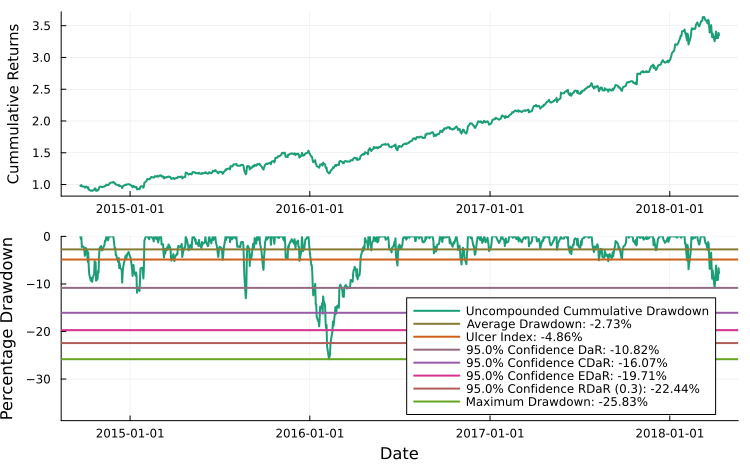

In [25]:
fig4 = plot_drawdown(portfolio)

# Compute the efficient frontier

The efficient frontier is a dictionary, whose keys are the risk measures used. 

Going into one of these keys reveals another dictionary. This dictionary contains information on the parameters used as well as the values for the risk and a dataframe of the weights for each asset at every point used. If the key `:sharpe` contains the value `true`, the last column of the `:weights` dataframe corresponds to the asset weights of the portfolio with the maximum risk adjusted return ratio.

In [26]:
frontier = efficient_frontier(portfolio; points = 50)
frontier[:SD]

Dict{Symbol, Any} with 8 entries:
  :risk    => [0.0077046, 0.00837589, 0.00904717, 0.00971846, 0.0103898, 0.0110…
  :sharpe  => true
  :weights => 20×52 DataFrame…
  :class   => :Classic
  :points  => 50
  :rf      => 0.0
  :hist    => 1
  :kelly   => :None

In [27]:
pretty_table(frontier[:SD][:weights]; formatters=wdffmt)

┌─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┐
│ tickers │       1 │       2 │       3 │       4 │       5 │       6 │       7 │       8 │       9 │      10 │      11 │      12 │      13 │      14 │      15 │      16 │      17 │      18 │      19 │      20 │      21 │      22 │      23 │      24 │      25 │      26 │      27 │      28 │      29 │      30 │      31 │      32 │      33 │      34 │      35 │      36 │      37 │      38 │      39 │      40 │      41 │      42 │      43 │      44 │      45 │      46 │      4

We can plot the efficient frontier.

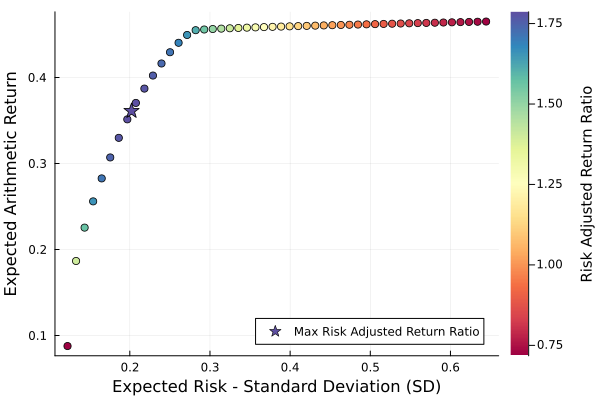

In [28]:
fig5 = plot_frontier(portfolio)

As well as the area plot of the frontier.

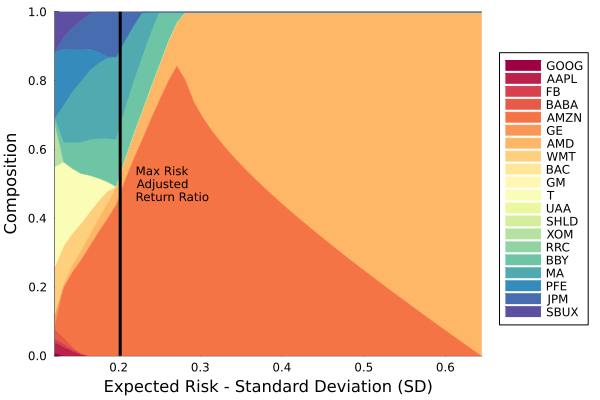

In [29]:
fig6 = plot_frontier_area(portfolio)

We can also view asset clusters, on which we will expand in later tutorials, but here are the examples.

In [30]:
# We instantiate a heirarchical portfolio instance.
hcportfolio = HCPortfolio(;
    # Returns dataframe
    returns=returns,
)
# We can then compute various statistics required for clustering.
asset_statistics!(hcportfolio)

We can view the correlation matrix and dendrogram with the proposed clusters. 

┌ Warning: Keyword argument `orientation` is deprecated.
│ Please use `permute` instead.
└ @ Plots C:\Users\jae29814\.julia\packages\Plots\sxUvK\src\args.jl:1552


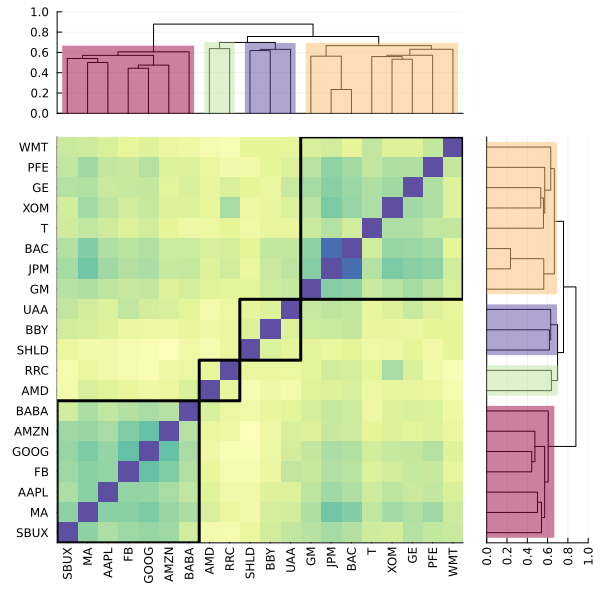

In [31]:
fig7 = plot_clusters(hcportfolio; linkage = :ward)

We can also simply plot the dendrograms with the highlighted clusters.

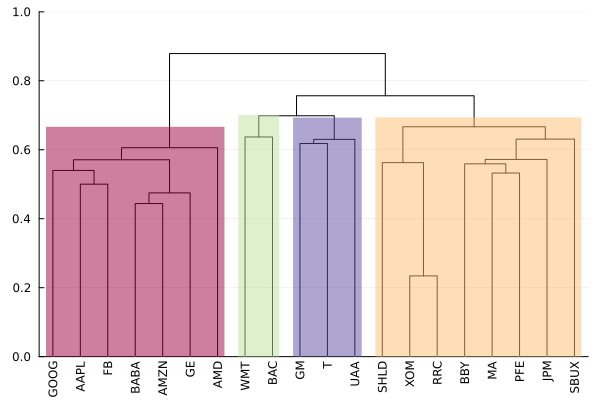

In [32]:
fig8 = plot_dendrogram(hcportfolio; linkage = :ward)